In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os

warnings.filterwarnings('ignore')
%matplotlib inline

# Load Datasets

In [2]:
def load_dataset(dataset):
    """ "loads a given hdf file"""
    data_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\raw"
    dataset_path = os.path.join(data_path, dataset)
    df = pd.read_hdf(dataset_path)

    return df

backgrounds = ["ttsemileptonic.hd5", "fully_leptonic.hd5", "fully_hadronic.hd5"]
signal = "ttH.hd5"

full_df = load_dataset(signal)
full_df['event_type'] = signal
full_df['signal'] = 1

for background in backgrounds:
    dataset = load_dataset(background)
    dataset['event_type'] = background
    dataset['signal'] = 0
    full_df = full_df.append(dataset, ignore_index=True)


# Remove Useless Columns

In [110]:
completely_useless_cols = ['entry', 'hashed_filename', 'xs_weight', 'weight_nominal', 'dataset']
useful_cols = list(set(full_df.columns) - set(completely_useless_cols))

full_df = full_df[useful_cols]

# Plot Correlation Matrix

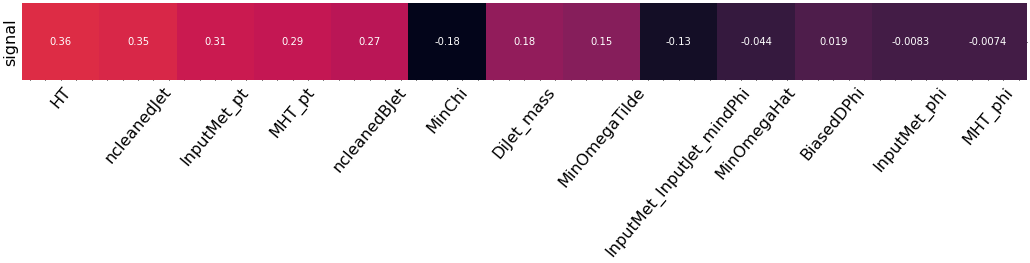

In [115]:
# shows how the signal correlates with other variables

with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']) as style:
    corrmat = full_df.corr()
    corr = corrmat[['signal']].sort_values(by=['signal'], ascending=False, key=abs)
    f, ax = plt.subplots(figsize=(18, 12))
    sns.heatmap(corr[1:].T, vmax=.8, annot=True, square=True, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 50)
    plt.show()

In [ ]:
with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']) as style:


In [189]:
# removes unnecessary columns
event_cols = ['BiasedDPhi',
               'HT', 
               'DiJet_mass',
               'MinChi',
               'InputMet_pt', 
               'InputMet_phi',
               'MHT_phi',
               'InputMet_InputJet_mindPhi',
               'MinOmegaHat',
               'MHT_pt',
               'MinOmegaTilde',
               'ncleanedJet',
               'ncleanedBJet', 
]


# splits data into training and validation
X, y = full_df.drop('signal', axis=1), full_df['signal']
useful_X = X[event_cols]
print("Removed Columns: ", set(X.columns) - set(event_cols))

Removed Columns:  {'cleanedJet_neHEF', 'cleanedJet_mass', 'cleanedJet_area', 'cleanedJet_pt', 'event_type', 'dataset', 'cleanedJet_btagDeepB', 'cleanedJet_phi', 'cleanedJet_chHEF', 'cleanedJet_eta'}


In [190]:
# shows mutual information score for each feature
from sklearn.feature_selection import mutual_info_classif

discrete_features = (useful_X.dtypes == int)

def make_mi_scores(useful_X, y, discrete_features):
    mi_scores = mutual_info_classif(useful_X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Score", index=useful_X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(useful_X, y, discrete_features)

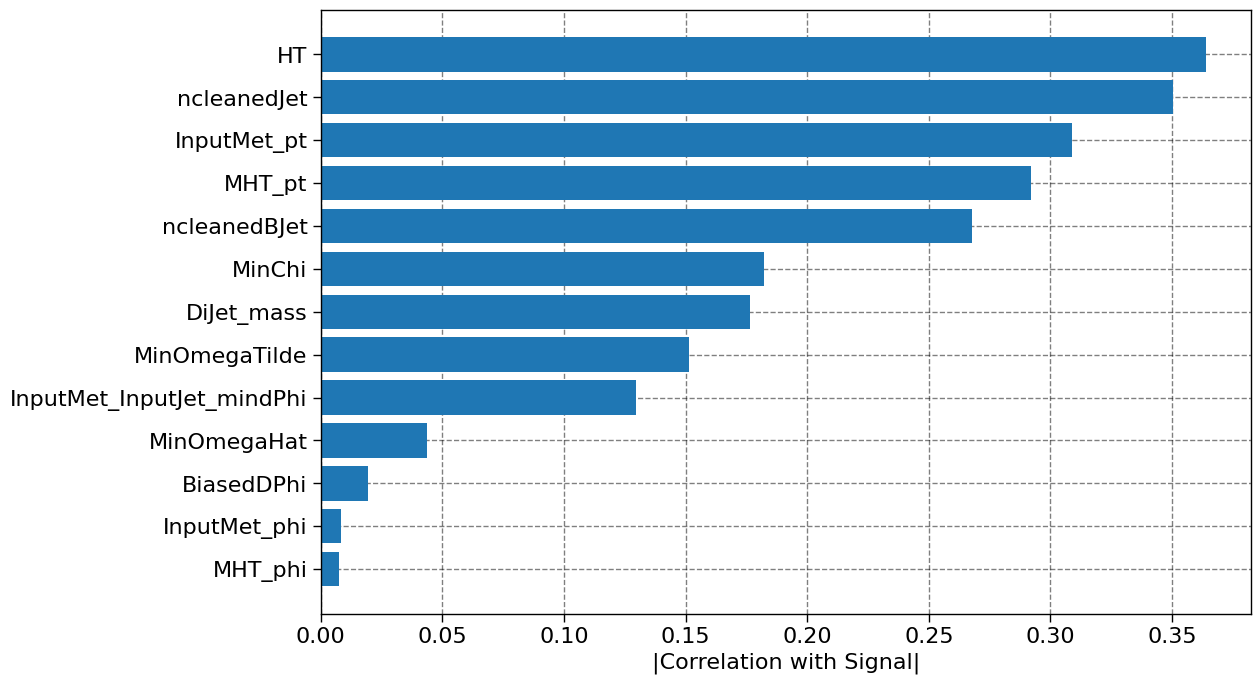

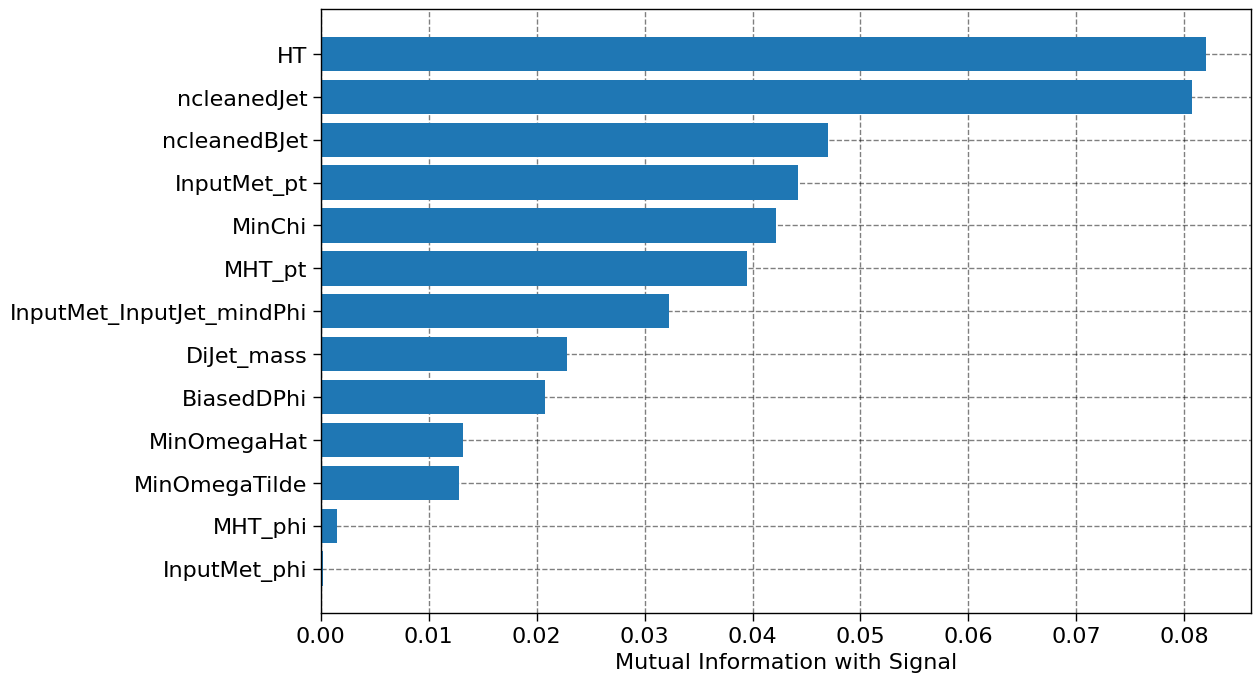

In [201]:
# plots the mutual information scores
def plot_scores(scores, xlabel):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    with plt.style.context(['nature', 'grid', 'notebook']):
        plt.figure(dpi=100, figsize=(12, 8))
        plt.barh(width, scores)
        plt.yticks(width, ticks)
        plt.xlabel(xlabel)

series_corr = corr.squeeze()
series_corr = series_corr.drop('signal')
series_corr = np.abs(series_corr)
series_corr = series_corr.sort_index()
mi_sorted = mi_scores.sort_index()

plot_scores(series_corr, "|Correlation with Signal|")
plot_scores(mi_sorted, "Mutual Information with Signal")

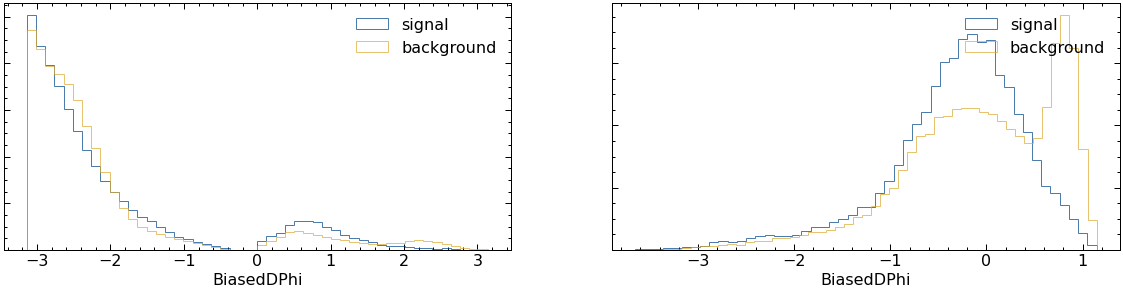

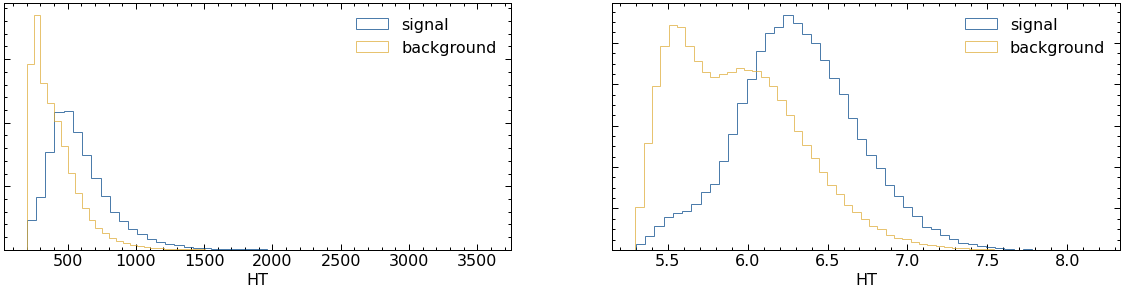

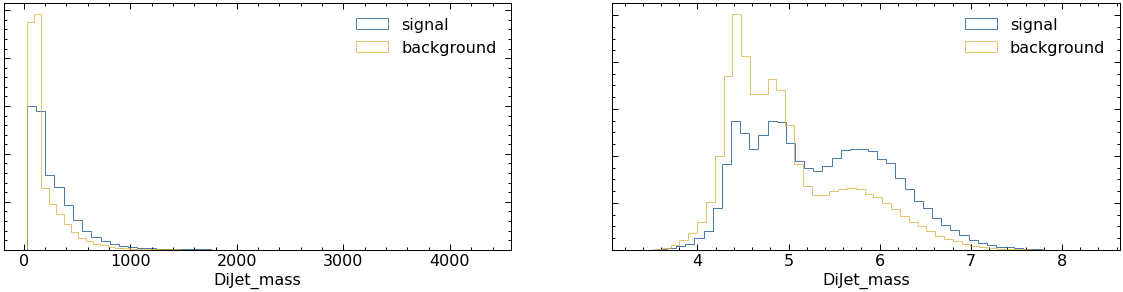

In [107]:
def hist_comparison(col_name, df):

    bins = 50

    signal = df[col_name].loc[df['signal'] == 1]
    bg = df[col_name].loc[df['signal'] == 0] 
    histtype = 'step'
    alpha = 0.7
    
    with plt.style.context(['science', 'notebook', 'high-contrast']) as style:
        
        plt.figure(figsize=(20,10))

        # skewed plot
        ax = plt.subplot(2,2,1)
        #plt.title(f'skewed {col_name} distribution')
        plt.xlabel(col_name)
        #plt.ylabel('Probability Density')
        plt.hist(signal, bins, alpha=alpha, label='signal', density=True, histtype=histtype)
        plt.hist(bg, bins, alpha=alpha, label='background', density=True, histtype=histtype)

        #ax.tick_params(labelbottom=False)
        ax.tick_params(labelleft=False)
        
        plt.legend()
        
        # unskewed plot
        unskewed_signal = np.log(signal)
        unskewed_bg = np.log(bg)
         
        ax = plt.subplot(2,2,2)
        #plt.title(f'unskewed {col_name} distribution')
        plt.xlabel(col_name)
        #plt.ylabel('Probability Density')
        plt.hist(unskewed_signal, bins, alpha=alpha, label='signal', density=True, histtype=histtype)
        plt.hist(unskewed_bg, bins, alpha=alpha, label='background', density=True, histtype=histtype)
        
        #ax.tick_params(labelbottom=False)
        ax.tick_params(labelleft=False)

        plt.legend()
        plt.show()


skewed_cols = ['BiasedDPhi',
               'HT', 
               'DiJet_mass',
               'MinChi',
               'MHT_phi',
               'InputMet_pt', 
               'InputMet_InputJet_mindPhi',
               'MinOmegaHat',
               'MHT_pt',
               'MinOmegaTilde',
               'InputMet_phi',
               'InputMet_pt',
]

interesting_cols = ['BiasedDPhi', 'HT', 'DiJet_mass']

for col in interesting_cols:
    hist_comparison(col, full_df)